In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce

import pytorch_warmup as warmup

from dit_core import DiffusionTransformer, EMA, _extract_into_tensor

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

(0.0, 350000.0)

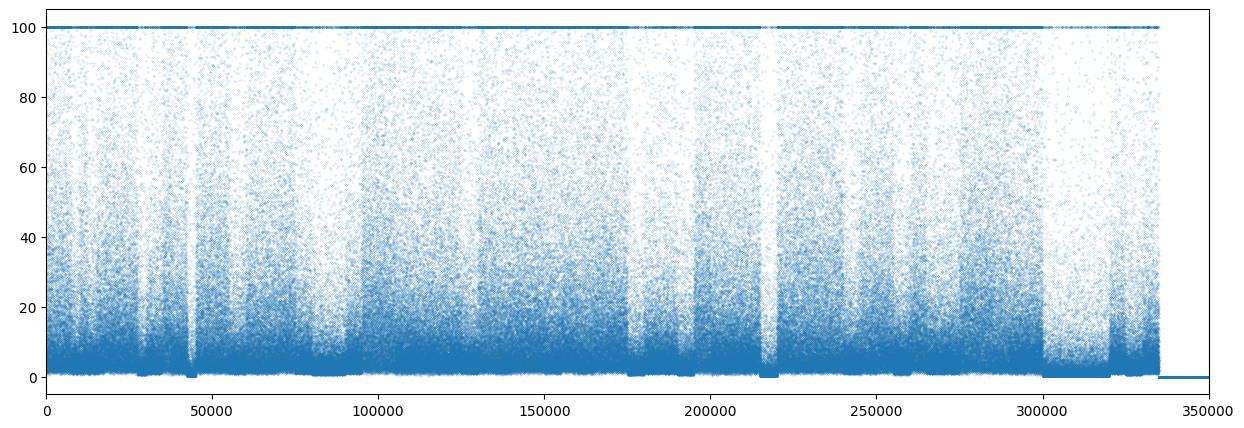

In [9]:
replay_buffer = pkl.load(open('../../data/replay_buffer_rope.pkl', 'rb'))

plt.figure(figsize=(15, 5))
plt.plot(replay_buffer['rew'], 'o' ,markersize=0.11)
plt.xlim(0, 350000)

In [10]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [11]:
class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    """ If num_samples, return a smaller dataset divided equally amnong multiple objects """
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def get_dataset_and_dataloaders(train_bs:int=128, val_bs:int=128, test_bs:int=1, num_samples:int=1000, rb_path='../../data/replay_buffer.pkl'):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    rewards = replay_buffer['rew']
    idxs1 = np.where(rewards > -20)[0]
    idxs2 = np.where(rewards != 0)[0]
    idxs = np.intersect1d(idxs1, idxs2)

    states = replay_buffer['obs'][idxs]
    actions = replay_buffer['act'][idxs]
    next_states = replay_buffer['obs2'][idxs]
    pos = replay_buffer['pos'][idxs]
    num_agents = replay_buffer['num_agents'][idxs]
    rewards = replay_buffer['rew'][idxs]
    done = replay_buffer['done'][idxs]
    
    dataset = get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples=num_samples)

    train_size = 0.7
    val_size = 0.15
    test_size = 0.15
    train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=(val_size + test_size))
    val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (test_size + val_size)))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)
    return train_loader, val_loader, test_loader

In [14]:
num_samples = 10000
train_loader, val_loader, test_loader = get_dataset_and_dataloaders(train_bs=64, val_bs=64, test_bs=1, num_samples=num_samples, rb_path='../../data/replay_buffer_rope.pkl')

In [15]:
len(train_loader), len(val_loader), len(test_loader)

(110, 24, 1500)

In [9]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer.pkl', 'wb'))

In [16]:
n_epochs = 100
hp_dict = {
        "exp_name"          : "MADP_1",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : int(n_epochs*num_samples*1e-3),
        'lr'                : 1e-3,
        'eta_min'           : 1e-6,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './madp_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_128.pth',

        # DiT Params:
        'state_dim'         : 6,
        'obj_name_enc_dim'  : 9,
        'action_dim'        : 2,
        "device"            : torch.device(f"cuda:0"),
        "model_dim"         : 128,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'denoising_decoder': 12},
        "dropout"           : 0,
        "max_grad_norm"     : 2.0,

        "denoising_params"  :{
            'num_train_timesteps'   : 100,
            'beta_start'        : 0.0001,
            'beta_end'          : 0.02,
            'beta_schedule'     : 'linear',
            'variance_type'     : 'fixed_small_log',
            'clip_sample'       : True ,
            'prediction_type'   : 'epsilon',
        },

        "EMA Params":{
            'update_after_step' : 0,
            'inv_gamma'         : 1.0,
            'power'             : 0.75,
            'min_value'         : 0.5,
            'max_value'         : 0.9999,
        }
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = DiffusionTransformer(hp_dict)
ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['device'])
optimizer = optim.AdamW(model.parameters(), lr=hp_dict['lr'], weight_decay=1e-6)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=hp_dict['eta_min'])

ema = EMA(ema_model, **hp_dict['EMA Params'])

train_losses = []
val_losses = []

In [17]:
# #load state dict
# model.load_state_dict(torch.load('madp_1000_sampl_100_steps_2.pth', weights_only=True)['model'])


In [18]:
global_Step = 0
start_value = 1
end_value = 1e2
steps = hp_dict['warmup_iters']

increment = (end_value - start_value) / (steps - 1)
values = [start_value + i * increment for i in range(steps)]

for param_group in optimizer.param_groups:
    param_group['lr'] = hp_dict['eta_min']

for epoch in range(hp_dict['epochs']):
    with tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=True, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])

            # Conditioning Variables
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])
            
            optimizer.zero_grad()
            loss = model.compute_loss(actions, states, pos)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            ema.step(model)

            if global_Step >= (steps-1):
                lr_scheduler.step()
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = hp_dict['eta_min'] * values[global_Step]

            train_losses.append(loss.item())
            t.set_postfix(train_loss=np.mean(train_losses[-300:]), refresh=False)
            global_Step += 1
        
        ema_model.eval()

    if epoch%20 == 0:
        model.eval()    
        with torch.no_grad():
            with tqdm.tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=True, mininterval=1) as v:
                for i, (s1, a, s2, p, r, d, N) in enumerate(v):
                    N = int(torch.max(N))
                    
                    # Noised and Denoised Variable
                    actions = a[:, :N].to(hp_dict['device'])
                    states = s1[:, :N].to(hp_dict['device'])
                    next_states = s2[:, :N].to(hp_dict['device'])
                    pos = p[:, :N].to(hp_dict['device'])
                    rewards = r.to(hp_dict['device'])
                    dones = d.to(hp_dict['device'])
                    noise = torch.randn((1, N, 2), device=hp_dict['device'])

                    denoised_actions, score_data = model.actions_from_denoising_diffusion(noise, states, pos)
                    val_losses.append(F.mse_loss(actions, denoised_actions).item())

                    v.set_postfix(val_loss=np.mean(val_losses[-len(val_loader):]), refresh=False)
                    if i == 50:
                        break
        model.train()

Training Epoch 99: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, train_loss=0.014]


In [ ]:
# This block is to break the sequence of run alls
assert True==False

In [20]:
expt_dict = {"model": model.state_dict(), "ema_model": ema_model.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(expt_dict, 'madp_mj.pt')

In [ ]:
madp_1000_sampl_100_steps_90_degrees_data

In [21]:
train_losses_bkp = train_losses
val_losses_bkp = val_losses

In [22]:
train_losses = train_losses_bkp
val_losses = val_losses_bkp

In [23]:
val_losses

[10094.537109375,
 2165.59033203125,
 2259.981689453125,
 4542.5556640625,
 4064.24951171875,
 4768.94873046875,
 1071.5390625,
 1332.8485107421875,
 4052.60498046875,
 4369.55078125,
 11581.9892578125,
 6371.70166015625,
 15590.087890625,
 2700.328125,
 5382.96484375,
 2778.369873046875,
 2842.950927734375,
 6475.97412109375,
 5253.4228515625,
 2260.149169921875,
 2239.03369140625,
 2528.116943359375,
 3865.868408203125,
 6698.341796875,
 0.0001677299296716228,
 0.00017195979307871312,
 0.00017107483290601522,
 0.0001709334464976564,
 0.00017676534480415285,
 0.00019001917098648846,
 0.0002055672084679827,
 0.00019465155492071062,
 0.00015802867710590363,
 0.00016981315275188535,
 0.00016558091738261282,
 0.00019887193047907203,
 0.00016416700964327902,
 0.00017706009384710342,
 0.00018599459144752473,
 0.00020500393293332309,
 0.00018505906336940825,
 0.00015154914581216872,
 0.00014004837430547923,
 0.00018519257719162852,
 0.0001891469000838697,
 0.00017578592814970762,
 0.00018396

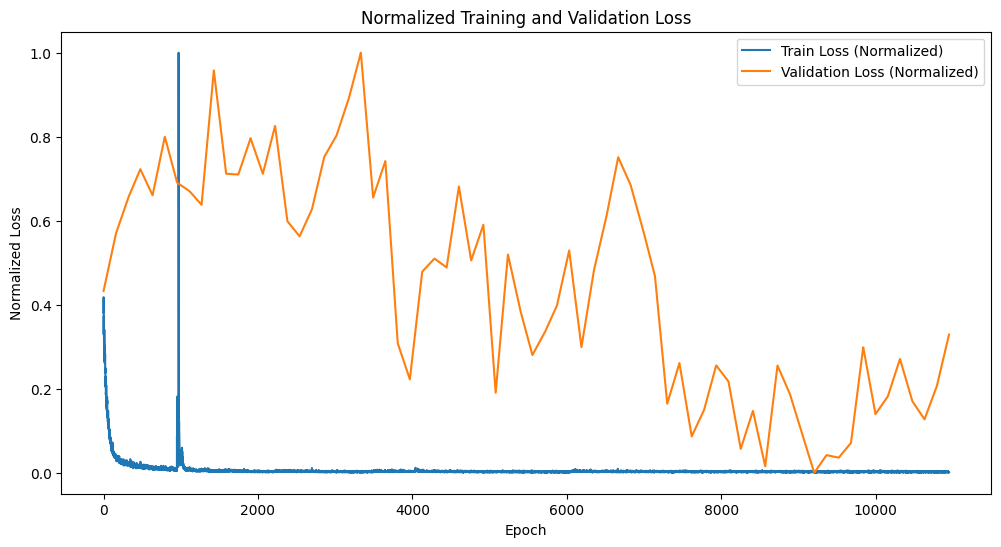

In [24]:
train_losses = np.array(train_losses_bkp[50:])
val_losses = np.array(val_losses_bkp[50:])
x_val = np.linspace(0, len(train_losses) - 1, len(val_losses))
x_train = np.arange(len(train_losses))
val_losses_interpolated = np.interp(x_train, x_val, val_losses)

# Step 2: Normalization of both losses
scaler = MinMaxScaler()


# combined_losses = np.concatenate((loss_train, loss_val_interpolated)).reshape(-1, 1)
# scaler.fit(combined_losses)

# Reshape for sklearn which expects 2D array
train_losses_normalized = scaler.fit_transform(train_losses.reshape(-1, 1)).flatten()
val_losses_normalized = scaler.fit_transform(val_losses_interpolated.reshape(-1, 1)).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses_normalized, label='Train Loss (Normalized)')
plt.plot(val_losses_normalized, label='Validation Loss (Normalized)')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Normalized Training and Validation Loss')
# plt.ylim(0, 0.1)
plt.legend()
plt.show()

In [25]:
import time
def actions_from_denoising_diffusion(model, x_T, states, obj_name_encs, pos, gamma=None):
    # actions get denoised from x_T --> x_t --> x_0
    actions = x_T
    shape = actions.shape
    score_data = []
    with torch.no_grad():
        for i in reversed(range(model.denoising_params['num_train_timesteps'])):
            t = torch.tensor([i]*shape[0], device=model.device)
            ### p_mean_variance
            pred_noise = model.denoising_decoder(actions, states, obj_name_encs, pos)
            score_data.append(pred_noise.detach().cpu().numpy())

            model_variance = _extract_into_tensor(model.posterior_variance, t, shape)
            model_log_variance = _extract_into_tensor(model.posterior_log_variance_clipped, t, shape)

            pred_x_start = _extract_into_tensor(model.sqrt_recip_alphas_cumprod, t, shape) * actions\
                        - _extract_into_tensor(model.sqrt_recipm1_alphas_cumprod, t, shape) * pred_noise
            
            model_mean = _extract_into_tensor(model.posterior_mean_coef1, t, shape) * pred_x_start\
                        + _extract_into_tensor(model.posterior_mean_coef2, t, shape) * actions
            
            ### p_sample
            noise = torch.randn(shape, device=model.device)
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(shape) - 1))))
            actions = model_mean + nonzero_mask * model_variance * noise
    return actions, np.array(score_data)

In [26]:
# num_samples = 5000
# train_loader2, val_loader2, test_loader2, state_scaler2, action_scaler2, obj_name_encoder2 = get_dataset_and_dataloaders(train_bs=256, test_bs=128, num_samples=num_samples, obj_of_interest=None)

In [27]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go


model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(test_loader, desc=f"Validation Epoch {epoch}", leave=False, mininterval=1) as v:
        for i, (s1, a, s2, p, r, d, N) in enumerate(v):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])
            noise = torch.randn((1, N, 2), device=hp_dict['device'])
            actions_gt.append(actions)
            statesss.append(states)
            possss.append(pos)

            now = time.time()
            denoised_actions, score_data = model.actions_from_denoising_diffusion(noise, states, pos)
            print(time.time() - now)
            # print(states, pos, obj_name_encs, denoised_actions)
            actionsss.append(denoised_actions)
            loss.append(F.mse_loss(actions, denoised_actions).item())

            if i==30:
                break

        # for i, (states, actions, obj_name_encs, pos, num_agents, rewards) in enumerate(v):
        #     # Print torch dtypes of all

        #     n_agents = int(torch.max(num_agents))
        #     # print(n_agents)
            
        #     # Noised and Denoised Variable
        #     actions = actions[:, :n_agents].to(hp_dict['device'])

        #     # Conditioning Variables
        #     states = states[:, :n_agents].to(hp_dict['device'])
        #     obj_name_encs = obj_name_encs.long().to(hp_dict['device'])
        #     pos = pos[:, :n_agents].to(hp_dict['device'])

        #     noise = torch.randn((1, n_agents, 2), device=hp_dict['device'])
        #     denoised_actions, score_data = actions_from_denoising_diffusion(model, noise, states, obj_name_encs, pos)
# denoising_steps, batchsize, N, _ = score_data.shape
# denoising_steps_range = np.arange(denoising_steps)
# agents_range = np.arange(N)
# denoising_steps_mesh, agents_mesh = np.meshgrid(denoising_steps_range, agents_range)

# # Compute the mean over the batch dimension for X and Y coordinates
# mean_x = score_data[:, :, :, 0].mean(axis=1)
# mean_y = score_data[:, :, :, 1].mean(axis=1)

# # Create the 3D surface plot
# fig = go.Figure(data=[go.Surface(x=denoising_steps_mesh, y=agents_mesh, z=mean_x)])

# # Update the layout
# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='Denoising Step'),
#         yaxis=dict(title='Agent'),
#         zaxis=dict(title='X Coordinate')
#     ),
#     title='Score Function Surface Plot'
# )

# # Add the second surface for Y coordinates
# fig.add_trace(go.Surface(x=denoising_steps_mesh, y=agents_mesh, z=mean_y,
#                          colorscale='Viridis', opacity=0.7, showscale=False))

# fig.write_html('score_function_plot.html')
# fig.show()

Validation Epoch 99:   0%|          | 0/1500 [00:00<?, ?it/s]

0.4177119731903076
0.41800498962402344


Validation Epoch 99:   0%|          | 3/1500 [00:01<10:28,  2.38it/s]

0.41894006729125977
0.4208986759185791
0.4180905818939209


Validation Epoch 99:   0%|          | 6/1500 [00:02<10:26,  2.38it/s]

0.41629862785339355
0.4182162284851074
0.4183523654937744


Validation Epoch 99:   1%|          | 9/1500 [00:03<10:25,  2.38it/s]

0.41947269439697266
0.4185521602630615
0.41857194900512695


Validation Epoch 99:   1%|          | 12/1500 [00:05<10:24,  2.38it/s]

0.41772961616516113
0.4166421890258789
0.4163942337036133


Validation Epoch 99:   1%|          | 15/1500 [00:06<10:22,  2.39it/s]

0.417921781539917
0.4158663749694824
0.4191780090332031


Validation Epoch 99:   1%|          | 18/1500 [00:07<10:20,  2.39it/s]

0.41709089279174805
0.41823244094848633
0.41777753829956055


Validation Epoch 99:   1%|▏         | 21/1500 [00:08<10:19,  2.39it/s]

0.4156043529510498
0.4190685749053955
0.4166841506958008


Validation Epoch 99:   2%|▏         | 24/1500 [00:10<10:23,  2.37it/s]

0.4529237747192383
0.4731113910675049
0.45154833793640137


Validation Epoch 99:   2%|▏         | 27/1500 [00:11<10:34,  2.32it/s]

0.418562650680542
0.4384450912475586
0.4675869941711426


Validation Epoch 99:   2%|▏         | 30/1500 [00:12<10:45,  2.28it/s]

0.4637565612792969


0.4166414737701416


4.5390160296172383e-05

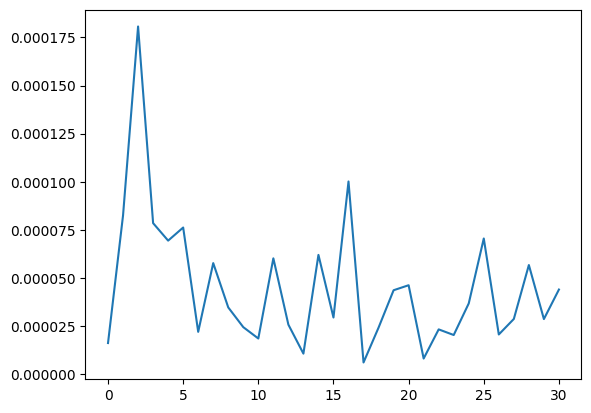

In [28]:
plt.plot(loss)
np.mean(loss)

In [51]:
statesss[0].detach().cpu().numpy().shape, len(statesss)

((1, 4, 6), 51)

[[-0.0139  0.0408]
 [ 0.038   0.0154]
 [-0.0349 -0.0435]
 [ 0.004   0.0164]]


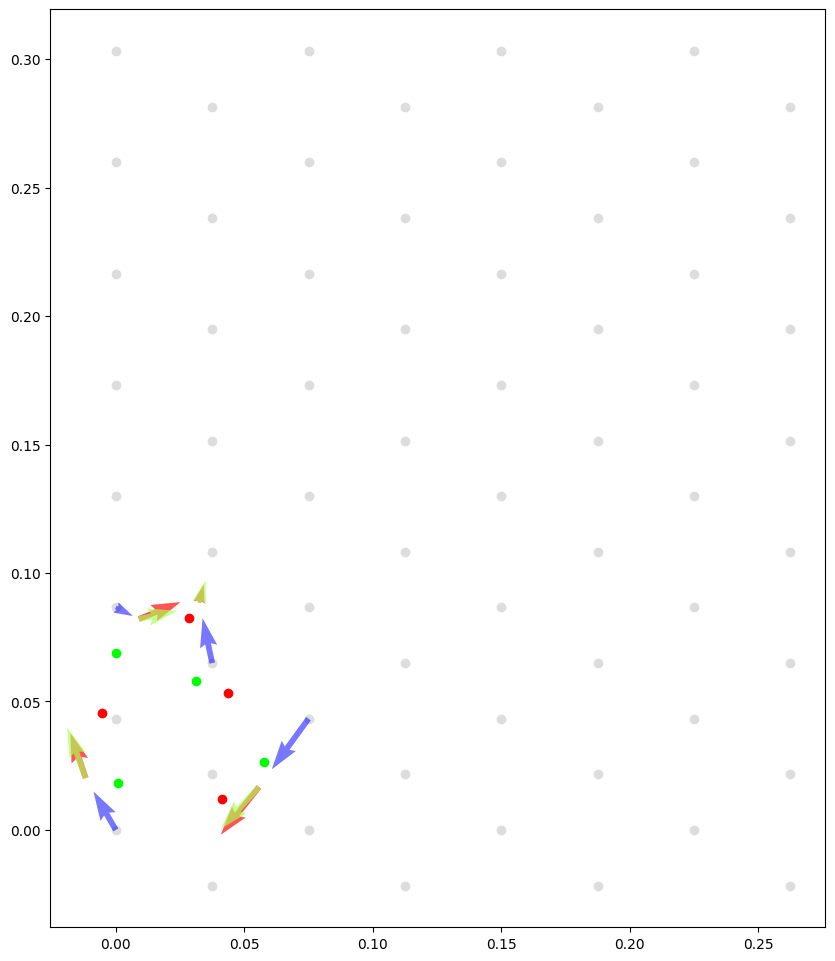

[[ 0.0147  0.002 ]
 [ 0.0148 -0.055 ]
 [-0.0127 -0.0215]
 [ 0.0358  0.0156]
 [-0.0183 -0.0411]
 [ 0.0077  0.0179]
 [-0.0216 -0.0013]]


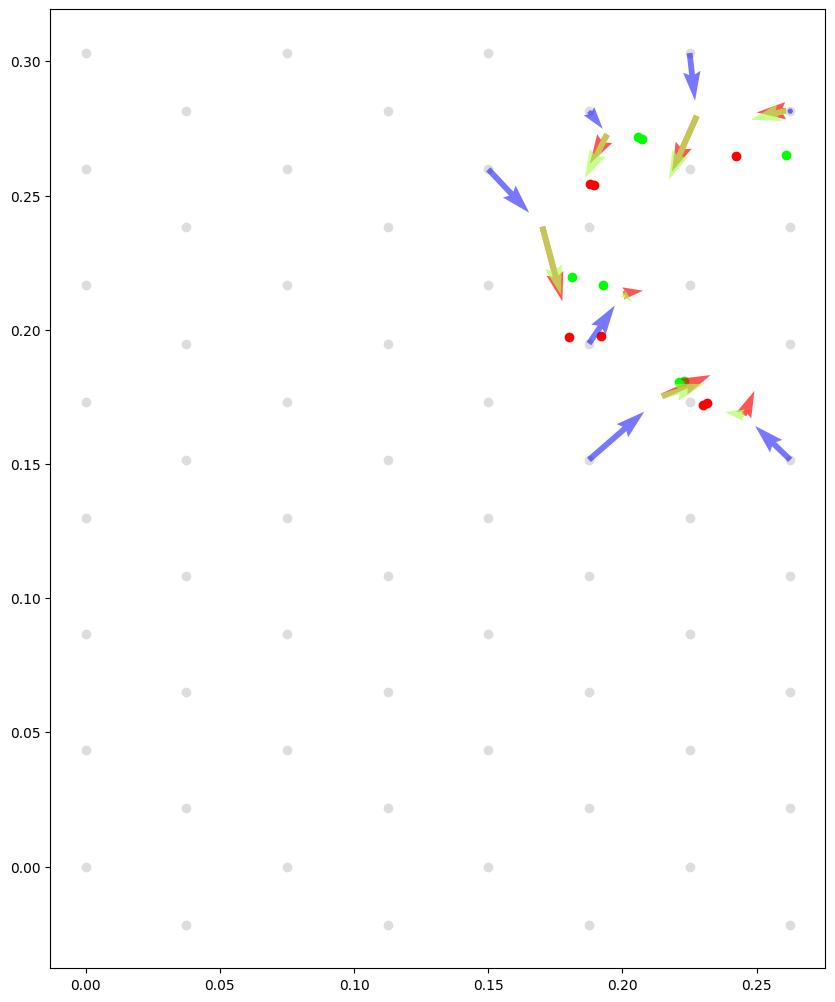

[[ 0.0015  0.0059]
 [ 0.0073  0.0314]
 [ 0.002  -0.0144]
 [ 0.0008 -0.0028]
 [-0.0101  0.0284]]


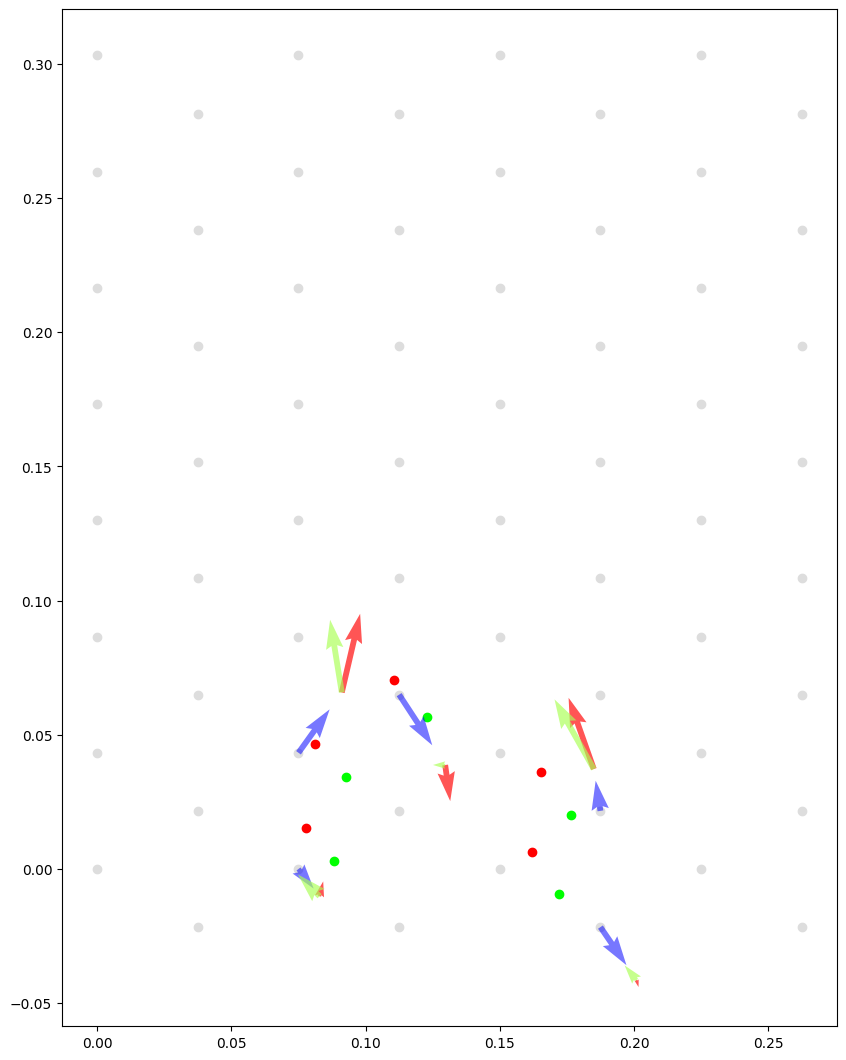

[[ 0.003   0.0341]
 [-0.0017  0.012 ]
 [ 0.0084 -0.0068]
 [-0.017   0.01  ]
 [-0.0329  0.0411]
 [-0.0192 -0.0195]]


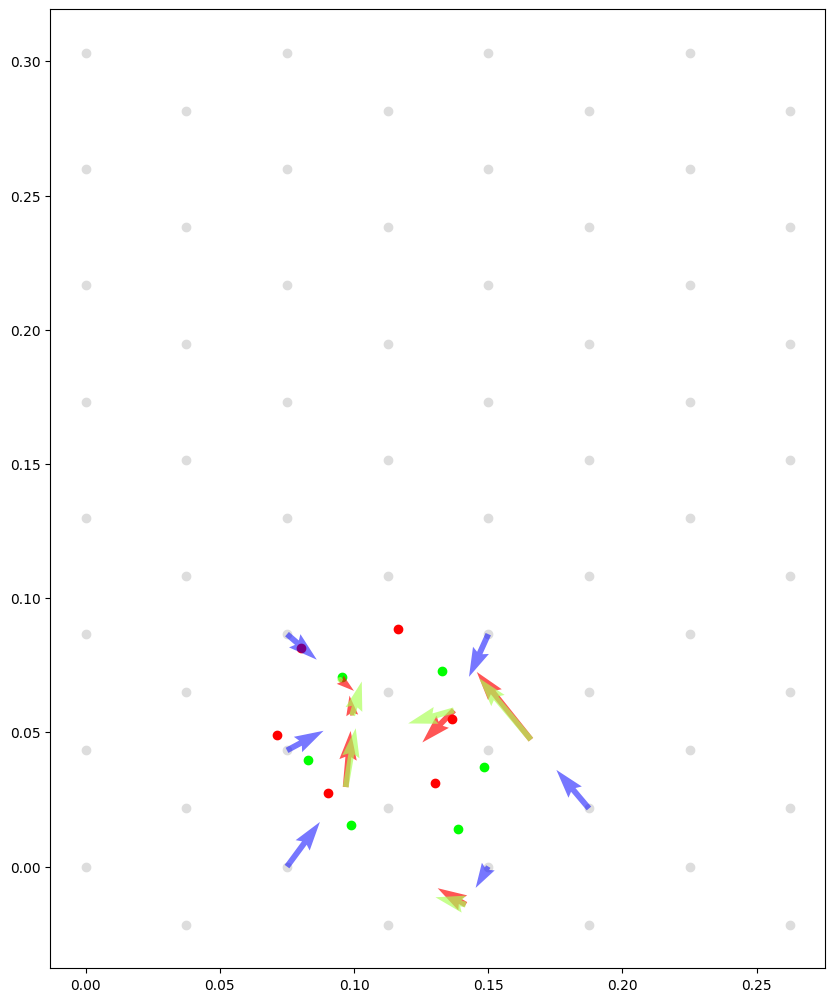

[[-0.0023  0.0328]
 [ 0.0221  0.0189]
 [ 0.0261  0.026 ]
 [ 0.0105 -0.009 ]
 [ 0.0083  0.0258]
 [-0.0023  0.0336]
 [-0.0088  0.0248]]


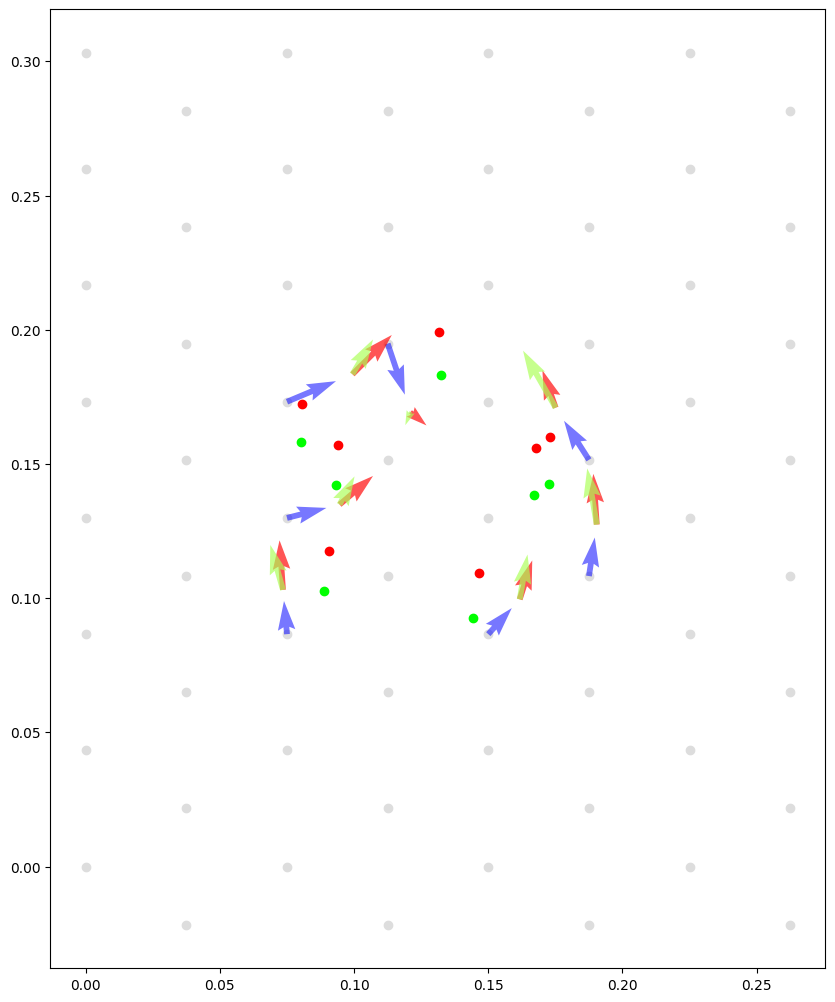

[[ 0.0306 -0.0068]
 [ 0.0362 -0.0145]
 [ 0.0316 -0.034 ]
 [ 0.0204  0.0008]
 [-0.0153 -0.0274]
 [ 0.0107  0.034 ]
 [-0.0163  0.0146]
 [ 0.0047 -0.0144]]


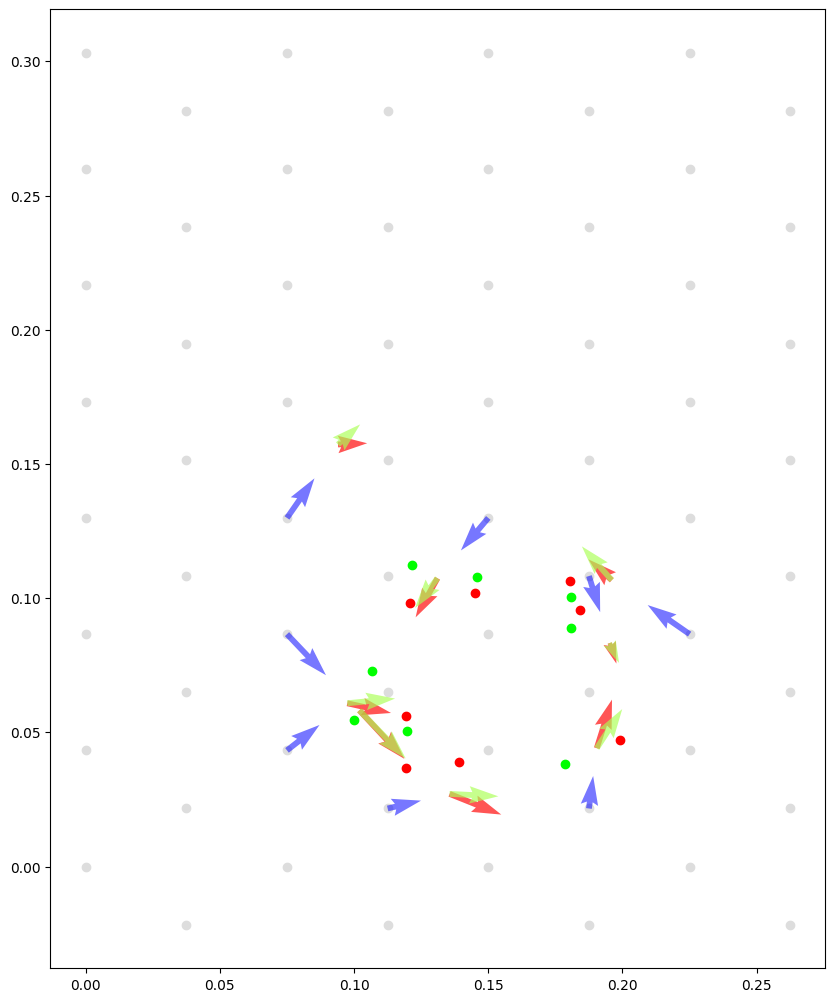

[[ 0.0124 -0.0236]
 [ 0.0266 -0.0328]
 [-0.0132 -0.0013]
 [-0.0218 -0.0357]
 [-0.0005 -0.0269]]


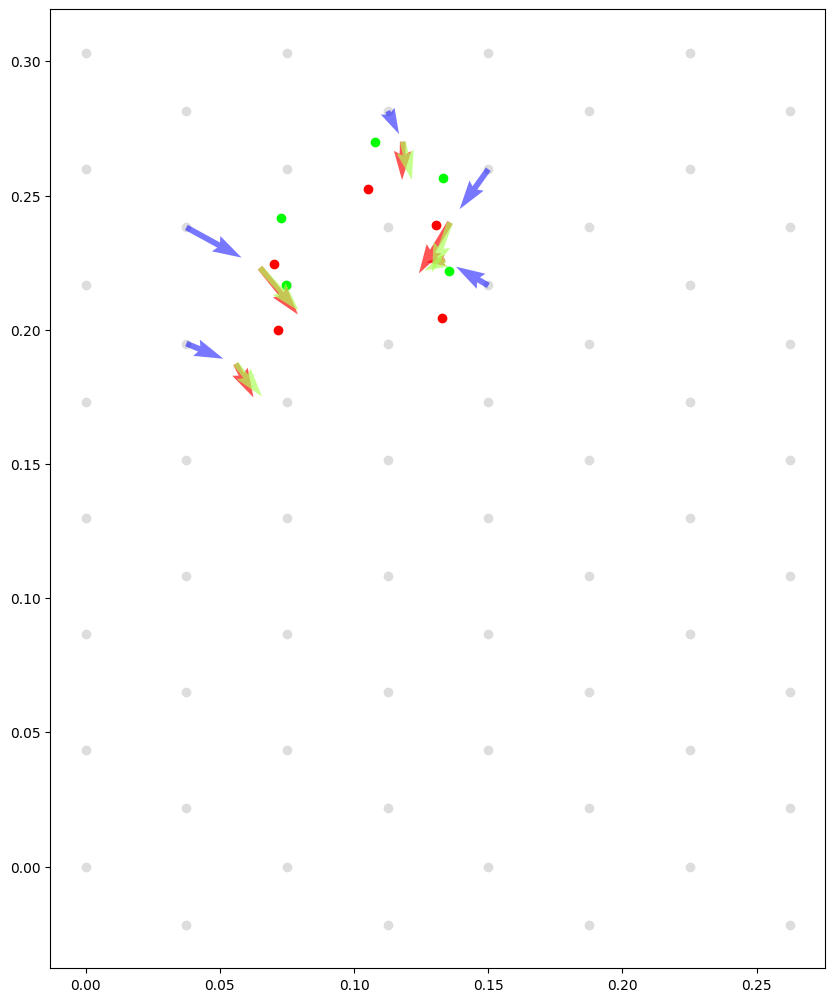

[[-0.0115  0.0165]
 [ 0.018   0.0234]
 [ 0.0142  0.0321]
 [ 0.0309  0.0091]
 [-0.0326  0.0285]
 [-0.0289 -0.0054]
 [-0.0306  0.0037]
 [-0.0082 -0.0311]]


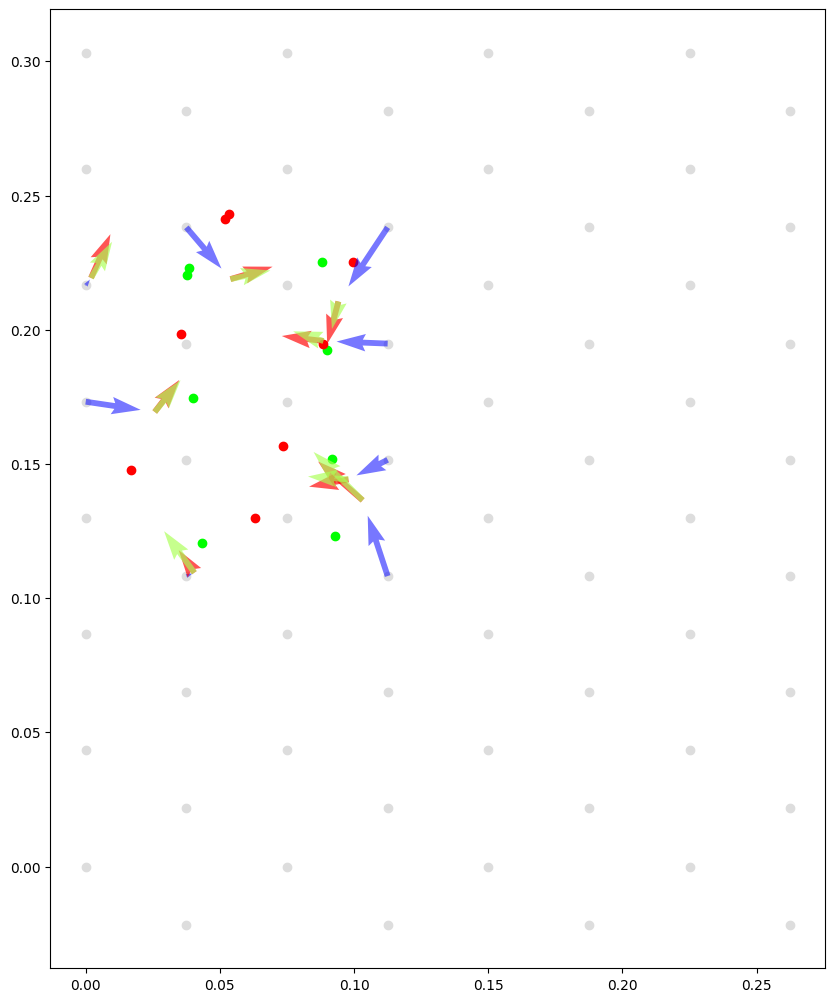

[[ 0.0076  0.0142]
 [-0.0189 -0.0252]
 [-0.0209 -0.0071]
 [-0.0177 -0.0084]
 [-0.0279 -0.0228]]


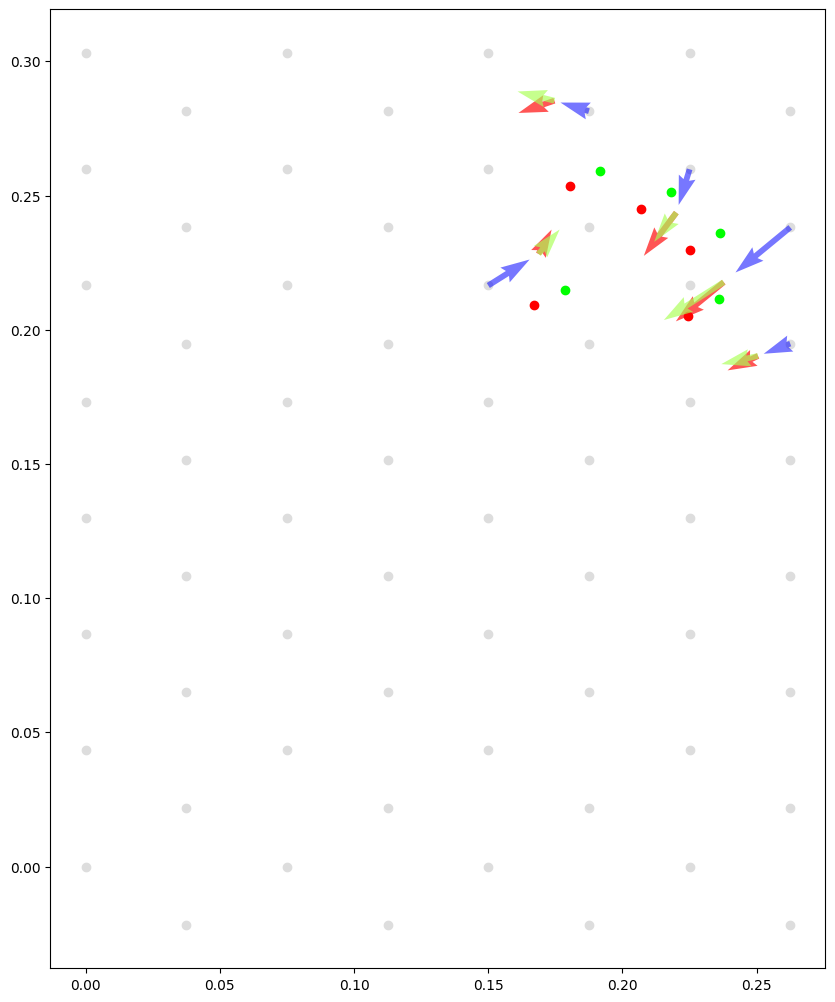

[[ 4.0121e-03 -1.3164e-02]
 [ 9.4245e-03 -1.8796e-02]
 [-1.6812e-02 -5.1692e-04]
 [ 2.3379e-02  5.2398e-03]
 [-3.0303e-02 -3.0135e-02]
 [-7.0713e-03  3.9481e-04]
 [ 6.3688e-05 -3.7460e-02]]


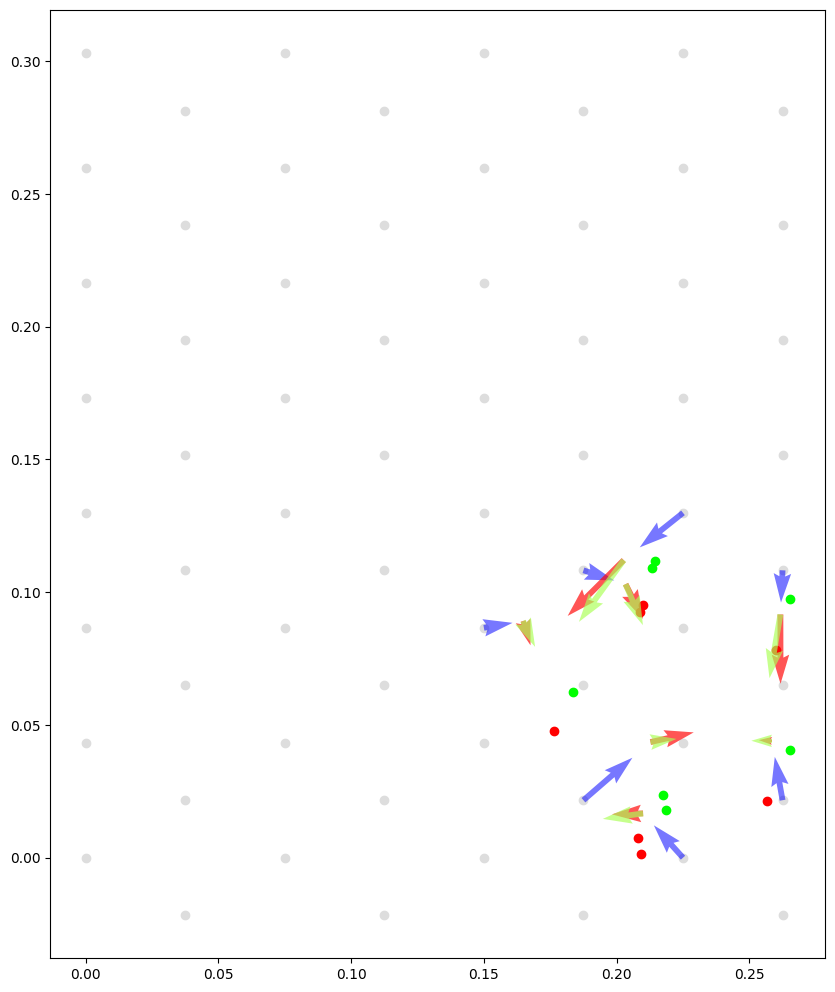

[[ 0.0013  0.0145]
 [ 0.0159  0.0015]
 [-0.0011 -0.0062]
 [ 0.0041  0.0096]
 [-0.0079  0.0328]
 [ 0.0099  0.0075]]


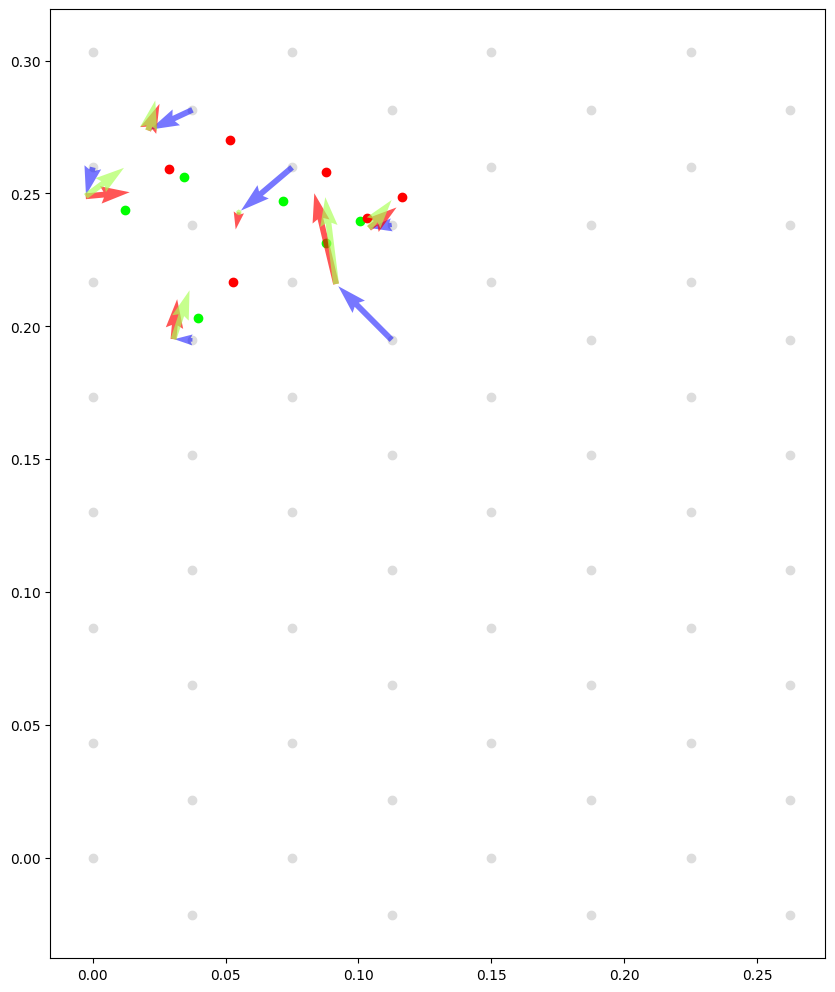

[[-0.0032  0.0257]
 [ 0.0136  0.01  ]
 [ 0.0208 -0.0329]
 [-0.0026  0.0101]
 [-0.0086 -0.0035]
 [-0.011   0.0076]]


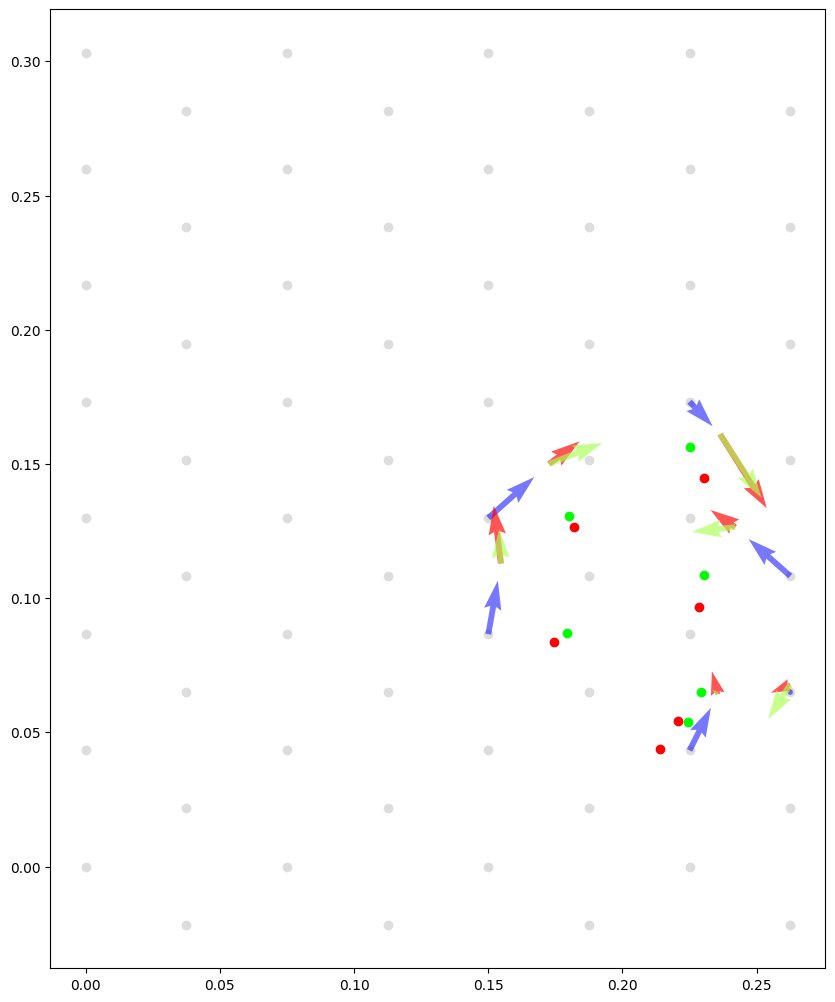

[[ 0.022  -0.0111]
 [ 0.0283  0.0035]
 [ 0.0373 -0.0309]
 [ 0.0003 -0.0369]
 [ 0.0139  0.0037]
 [ 0.0135 -0.0009]
 [ 0.0068 -0.0161]]


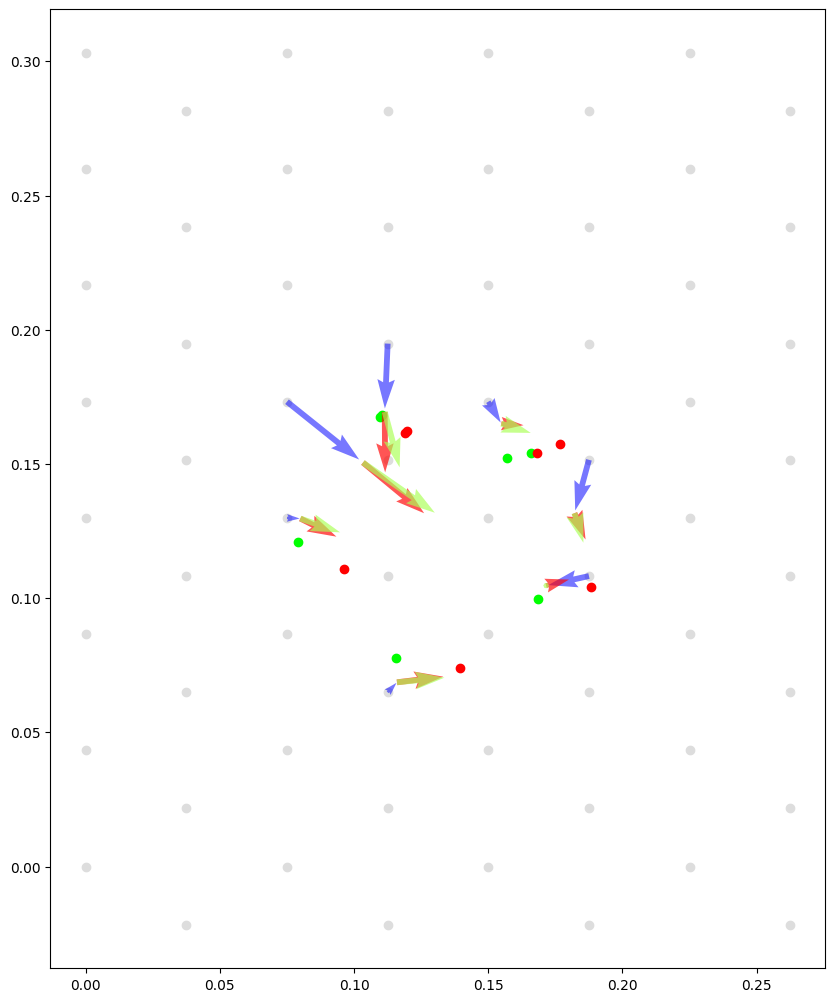

[[ 0.0209  0.0169]
 [ 0.0095  0.0018]
 [-0.0122  0.0148]
 [-0.007  -0.0245]
 [-0.005   0.0117]]


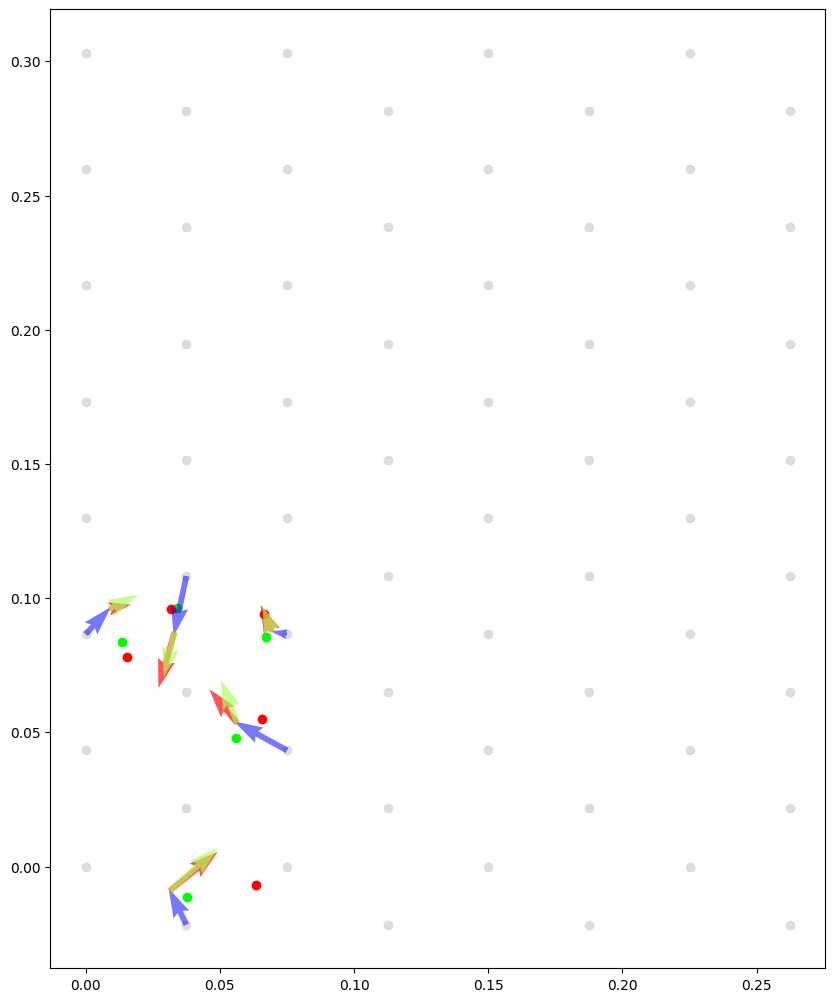

[[ 0.0497  0.0408]
 [ 0.0564  0.0102]
 [ 0.0023  0.0083]
 [ 0.017   0.0128]
 [ 0.0578 -0.0172]
 [-0.0146  0.0205]
 [ 0.0099 -0.0273]
 [ 0.0264 -0.0067]
 [-0.009  -0.0166]
 [-0.0571 -0.0023]]


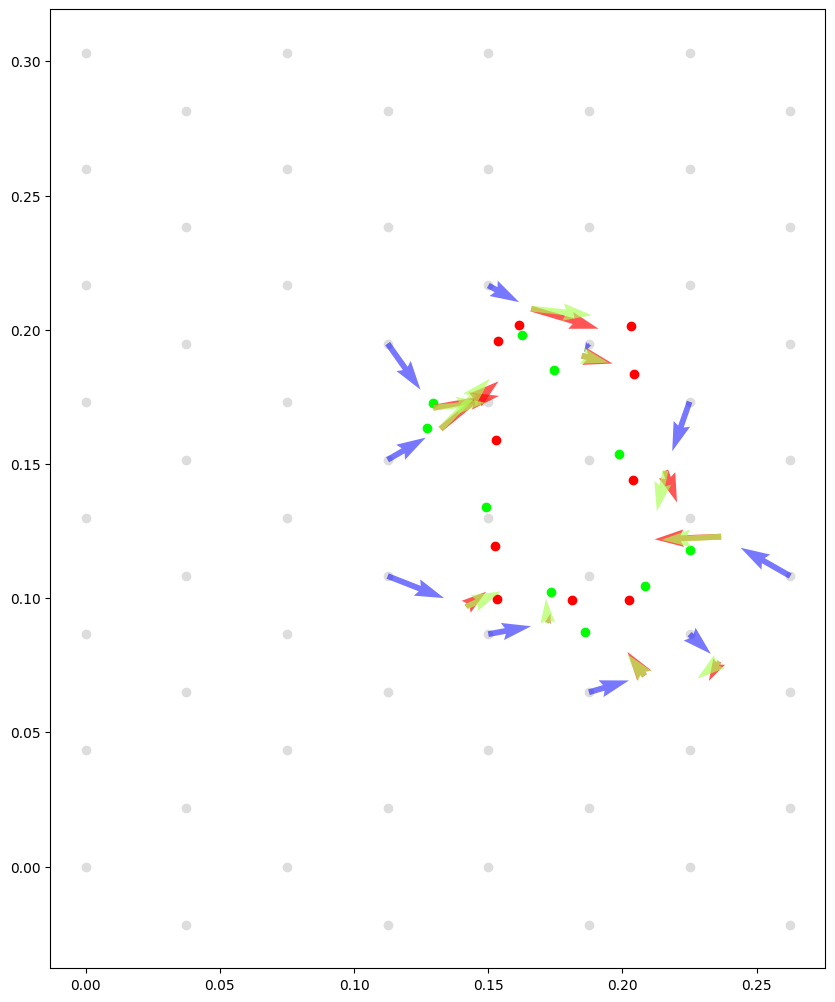

[[-0.0155 -0.0089]
 [-0.0288 -0.0064]
 [ 0.0003 -0.0269]
 [-0.0301 -0.0169]]


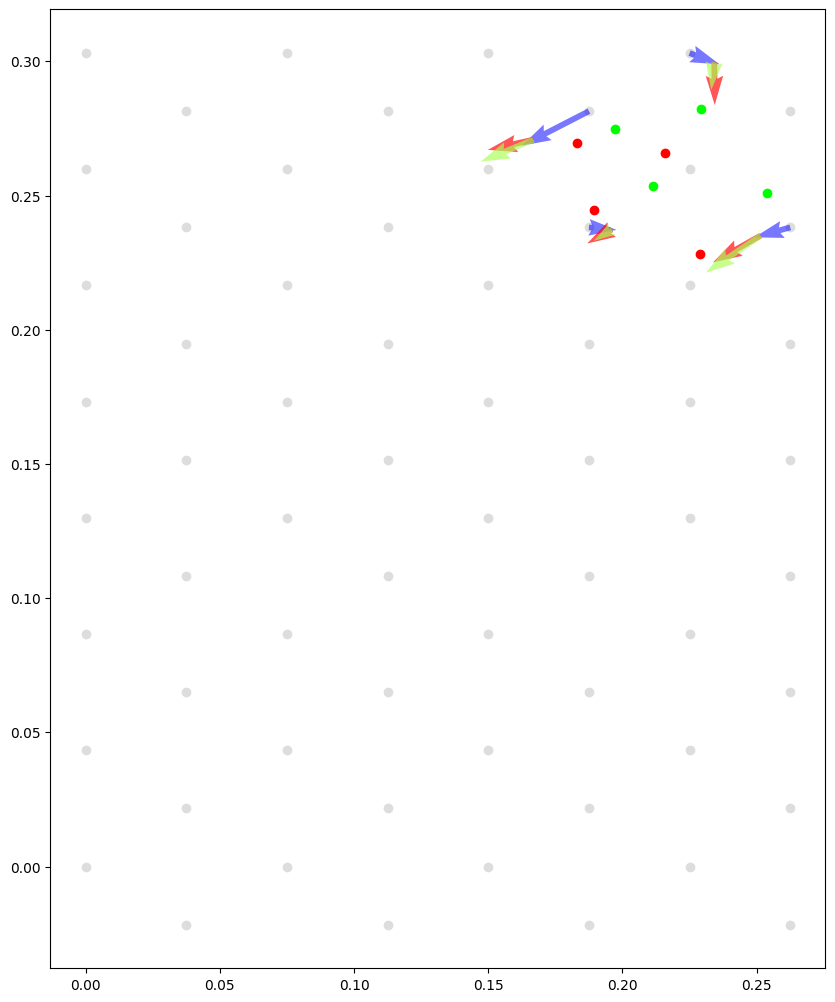

[[ 0.0398 -0.0459]
 [ 0.0727 -0.0037]
 [ 0.0195 -0.0242]
 [ 0.0558  0.0457]
 [-0.016  -0.0057]
 [ 0.0097  0.0297]
 [-0.04    0.0628]
 [-0.0336  0.0411]]


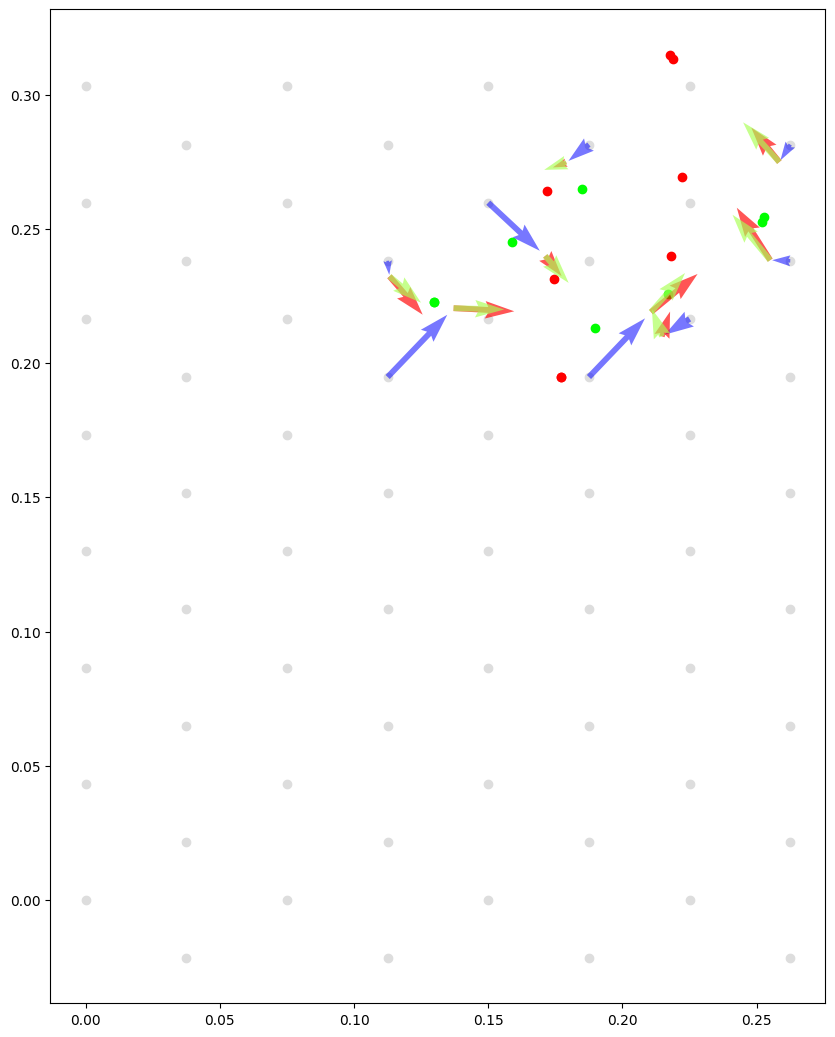

[[ 0.0079 -0.0063]
 [-0.0117 -0.01  ]
 [-0.035  -0.0115]
 [-0.0061  0.0012]
 [-0.0325  0.0249]]


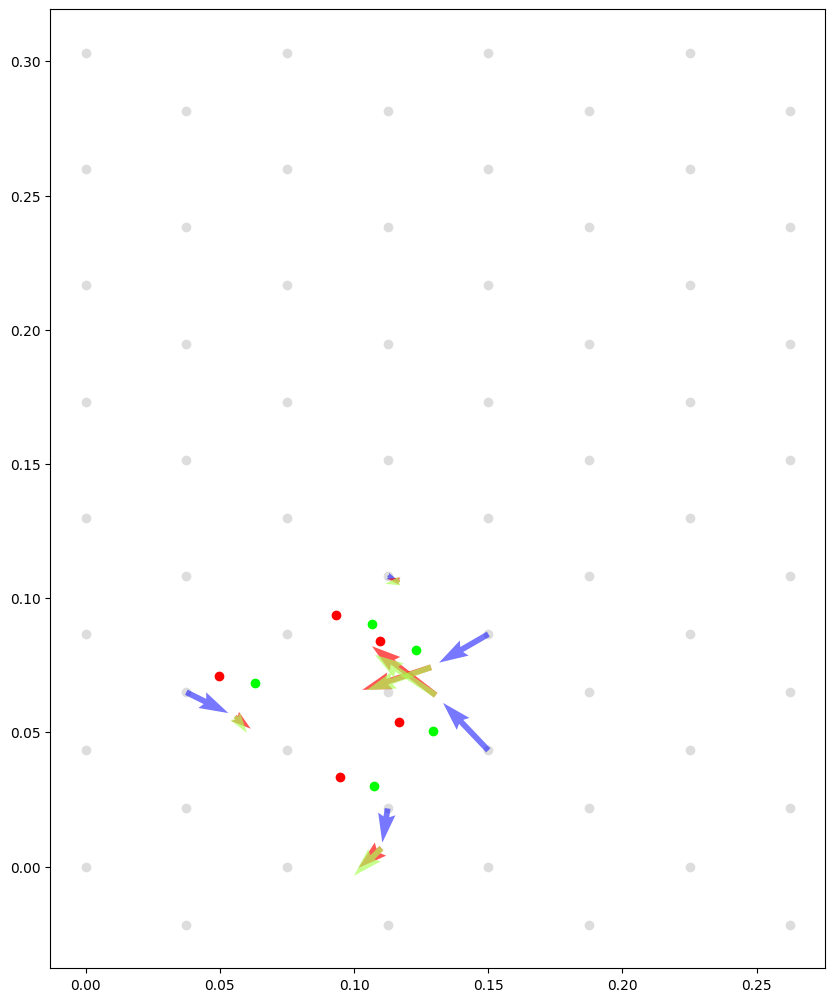

[[ 0.0096  0.0355]
 [ 0.0055  0.0209]
 [-0.0182 -0.001 ]
 [-0.0151  0.0255]
 [-0.0281  0.0045]
 [-0.0274 -0.0201]]


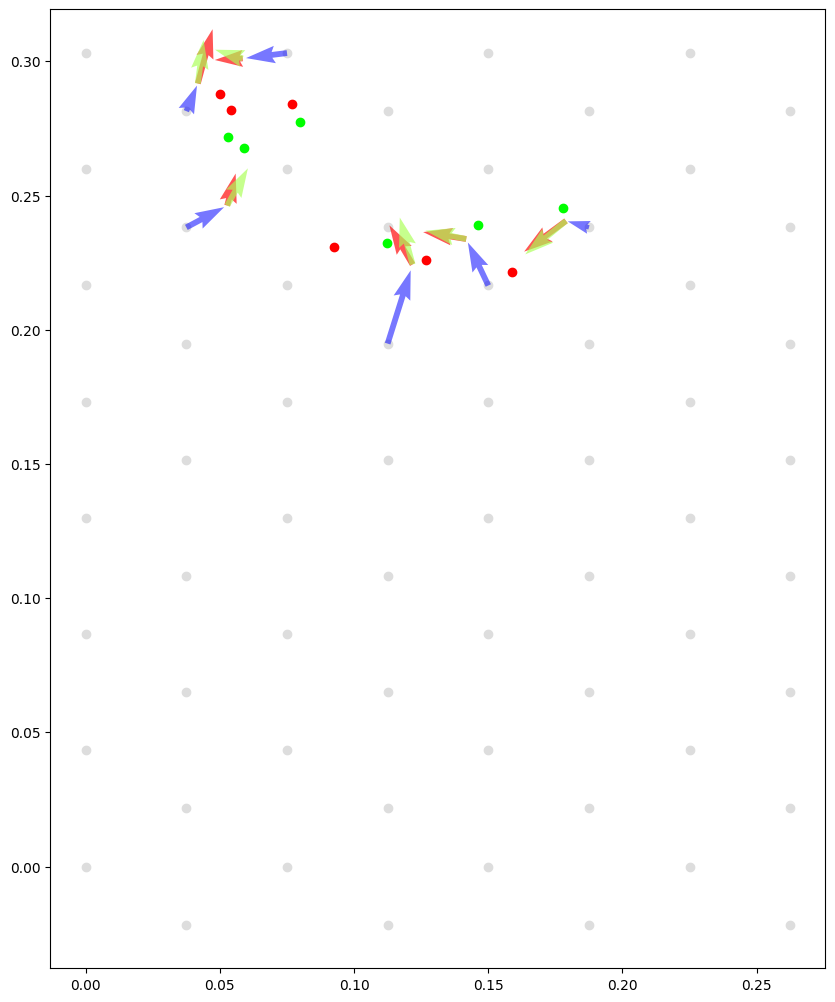

[[ 0.0063 -0.0162]
 [-0.0085 -0.0186]
 [ 0.0083  0.0039]
 [ 0.0342 -0.0354]
 [-0.0221 -0.0256]
 [-0.0009 -0.037 ]
 [-0.0069 -0.0189]]


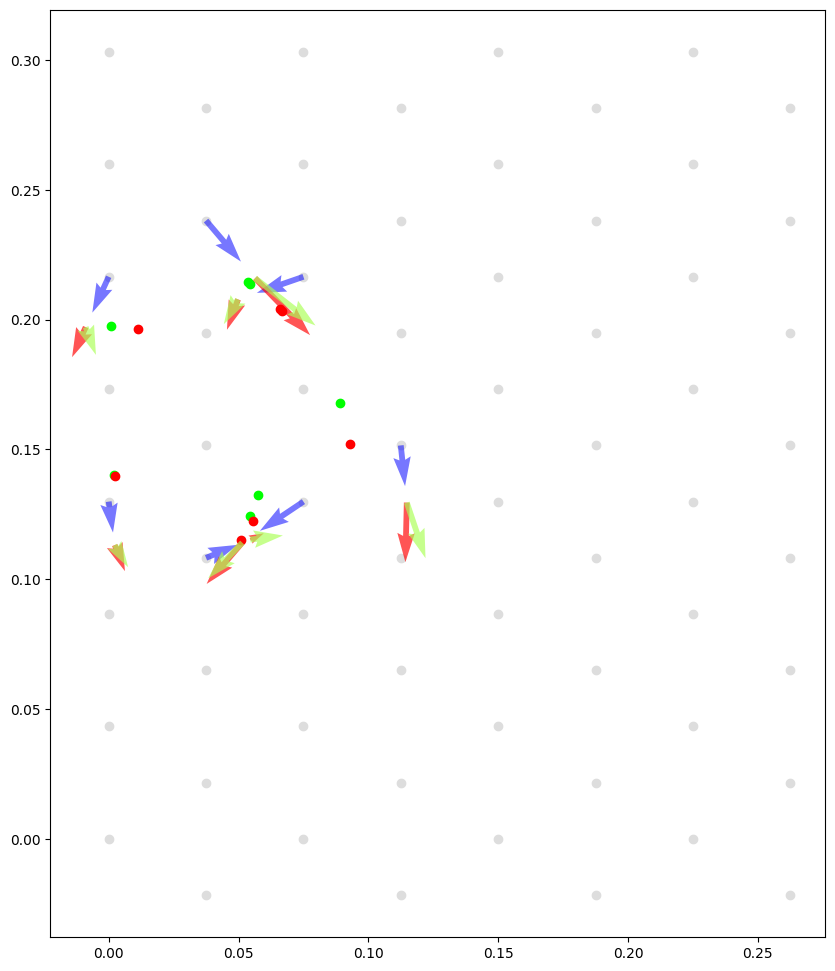

[[ 0.0344 -0.0497]
 [ 0.0242  0.0056]
 [-0.0104 -0.0346]
 [-0.025   0.0296]
 [-0.0269 -0.0144]
 [-0.0216  0.024 ]
 [-0.0553 -0.0059]
 [-0.0117 -0.0193]]


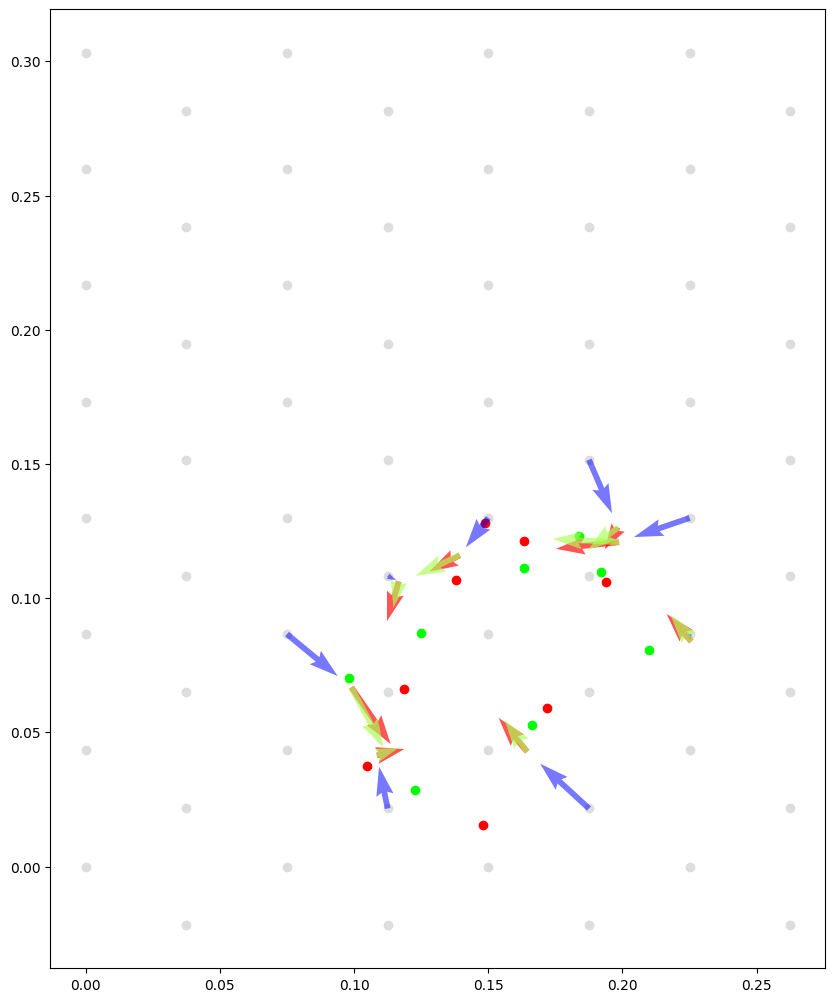

[[ 0.0091 -0.0202]
 [ 0.0086  0.0028]
 [-0.0043 -0.0211]
 [-0.0134  0.0265]
 [-0.0338  0.0239]]


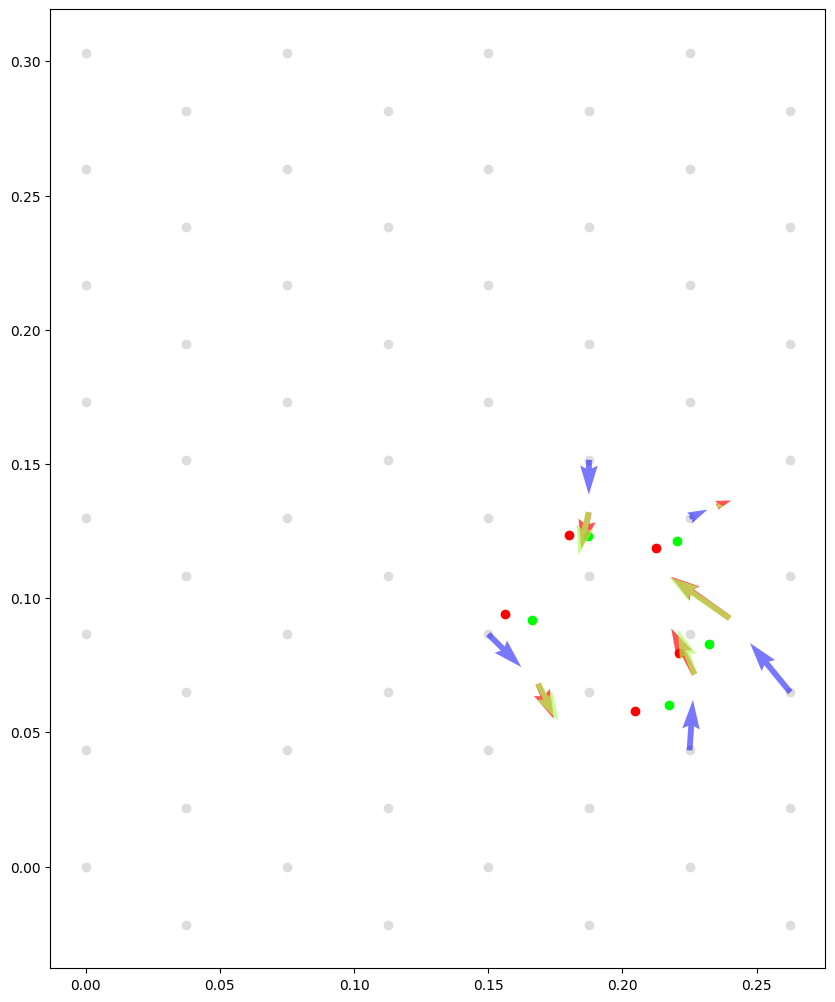

[[ 0.0306  0.0299]
 [ 0.0101 -0.0092]
 [ 0.0185 -0.0238]
 [ 0.0363  0.0134]
 [-0.0034 -0.0157]
 [-0.0174  0.017 ]
 [ 0.0071  0.0084]
 [-0.0069  0.0127]]


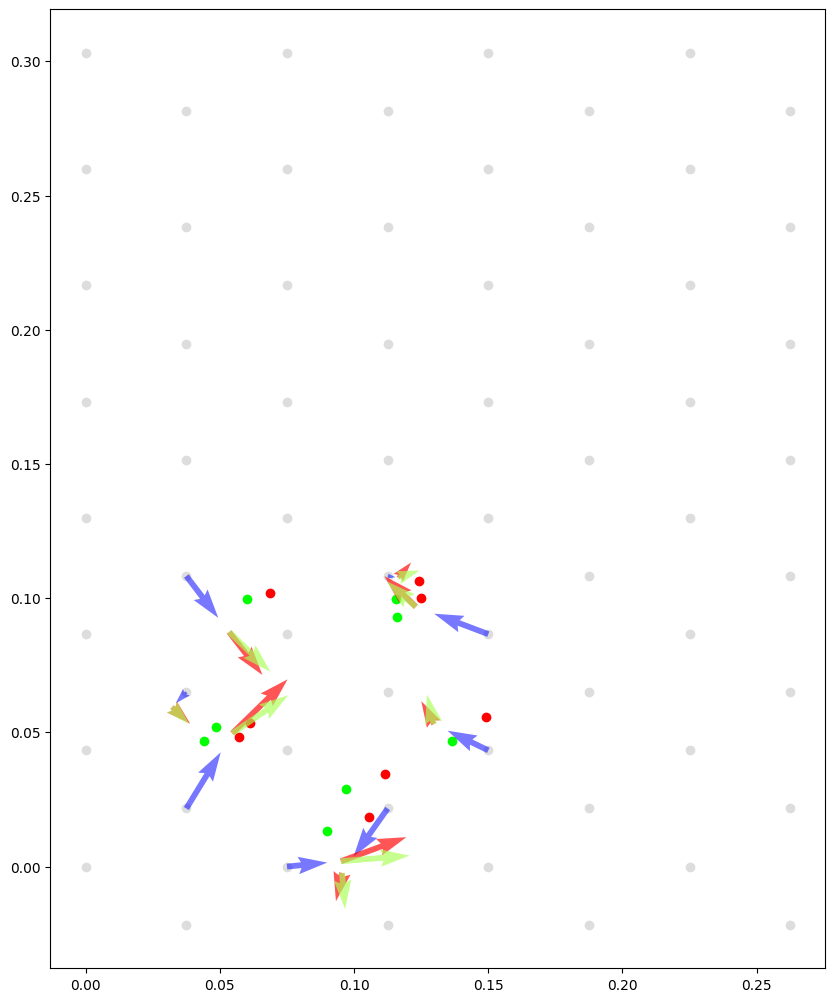

[[-0.0104  0.0049]
 [-0.0013  0.0216]
 [-0.0011 -0.0075]
 [-0.0074 -0.0115]
 [-0.0235 -0.0213]
 [-0.0088 -0.0421]]


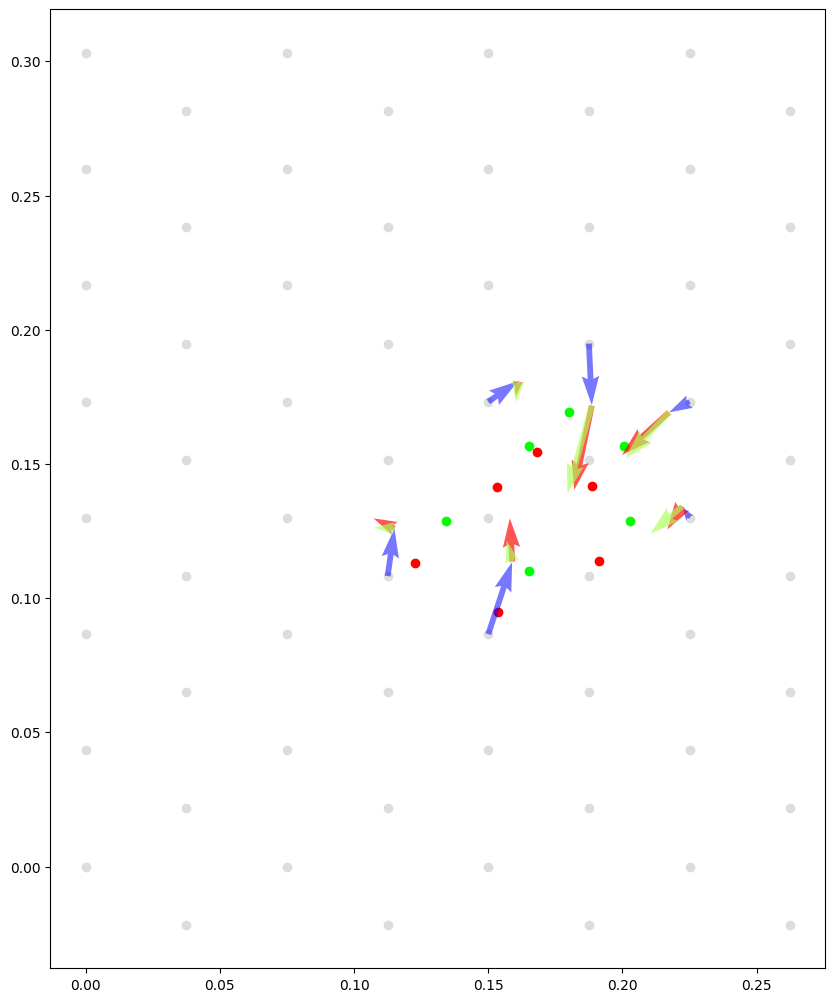

[[ 0.0159  0.0068]
 [ 0.0549  0.0123]
 [ 0.0322 -0.01  ]
 [-0.0156  0.0334]
 [ 0.0038  0.0318]
 [ 0.0223 -0.0177]
 [-0.005   0.0285]]


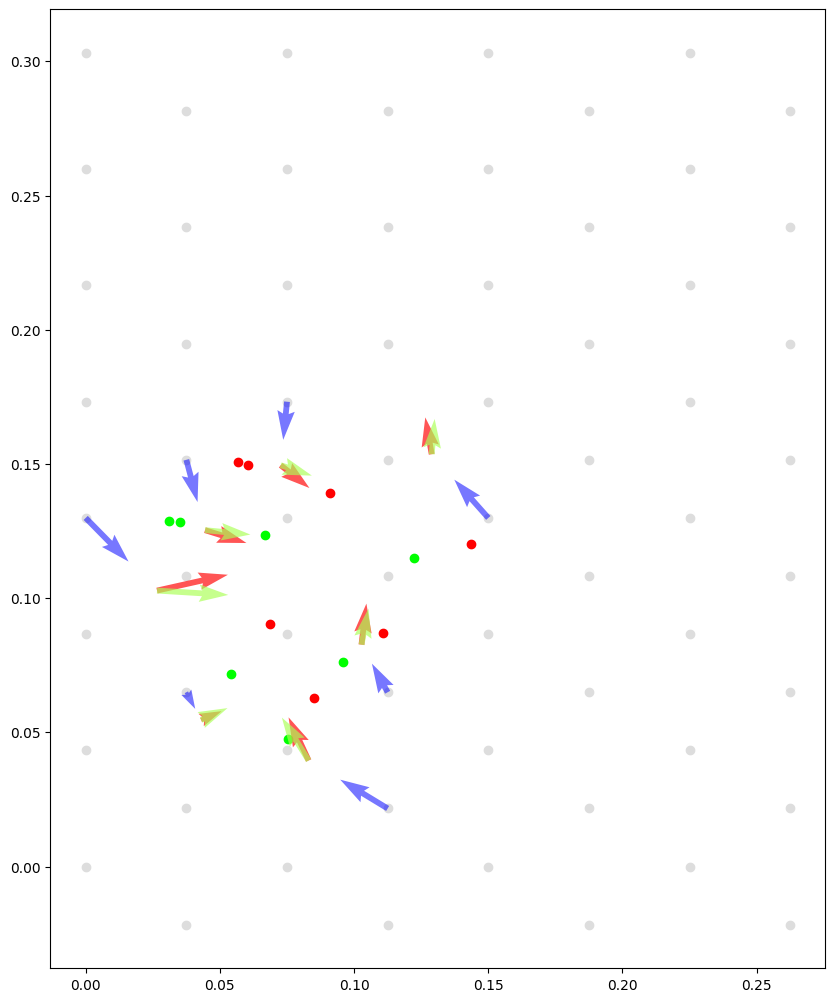

[[ 0.0137  0.0022]
 [-0.0342  0.0014]
 [-0.0002  0.0025]
 [-0.0021 -0.023 ]
 [-0.0042 -0.0122]
 [-0.0167  0.0073]
 [ 0.0023 -0.0308]
 [-0.0128 -0.0415]
 [-0.0085 -0.0294]]


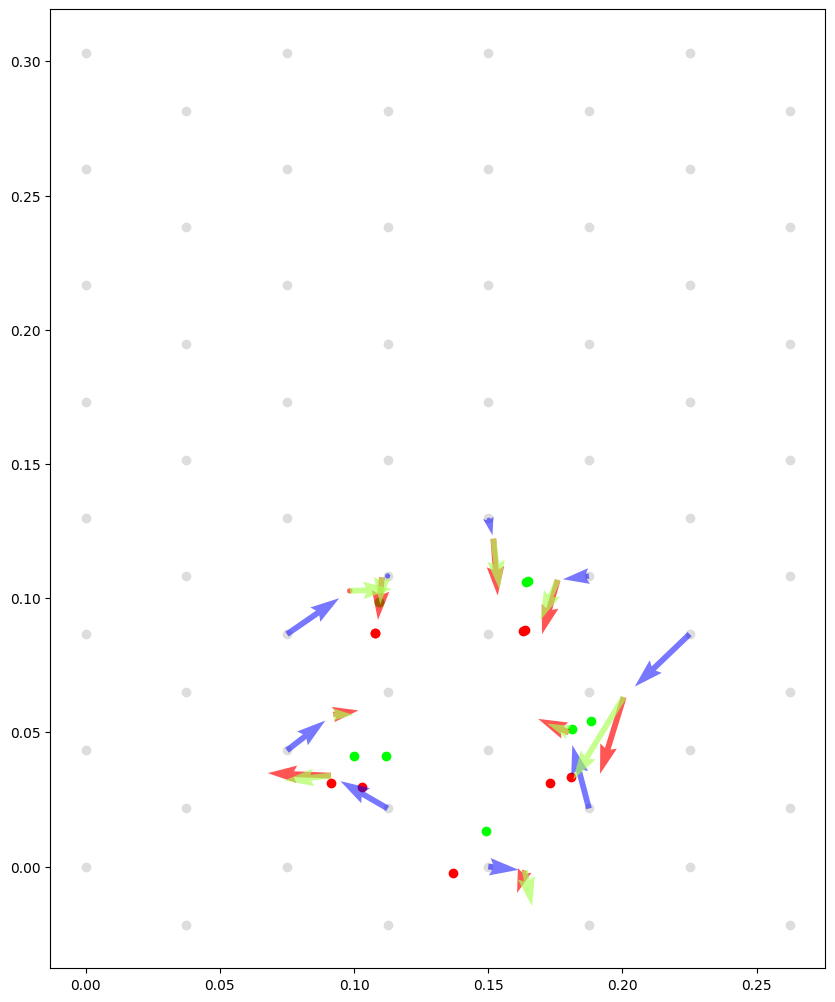

[[ 3.6381e-04  6.4526e-05]
 [ 3.2035e-02 -2.2340e-02]
 [ 6.5005e-03  6.0470e-03]
 [-3.9920e-03 -4.6015e-03]
 [ 6.4590e-03 -1.6092e-02]]


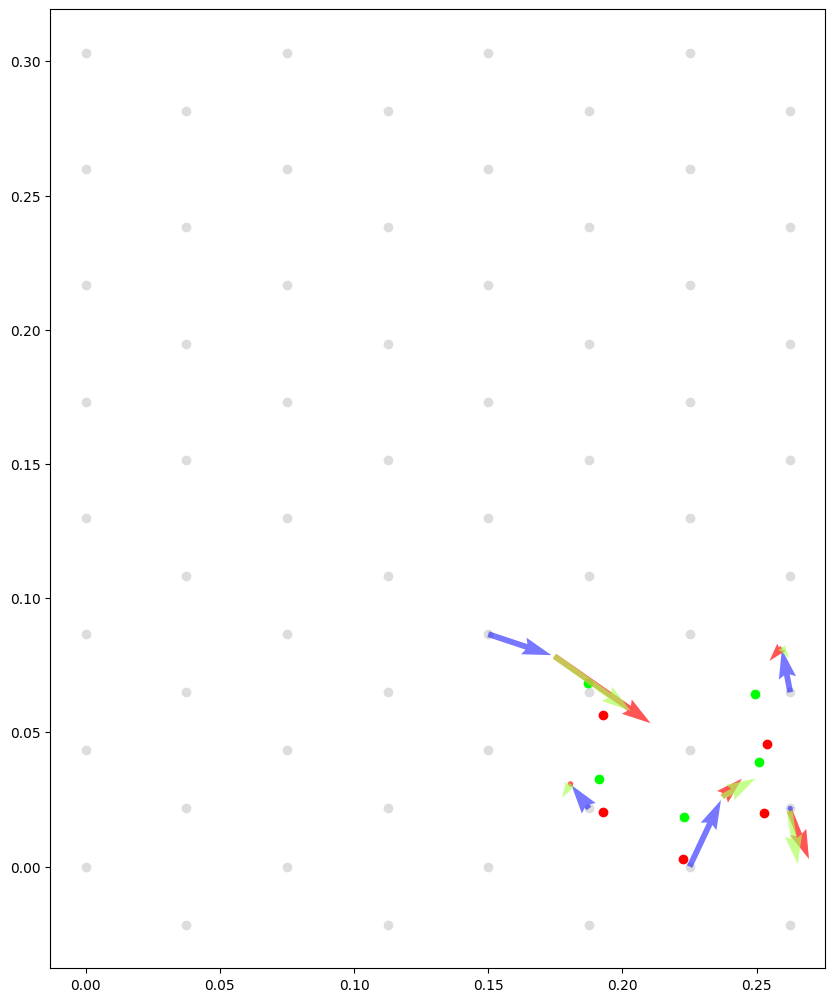

[[-0.0025 -0.0257]
 [ 0.0111 -0.035 ]
 [-0.0008  0.0283]
 [-0.0064 -0.0324]
 [-0.0187  0.0188]
 [-0.006   0.0099]
 [ 0.0116 -0.0151]]


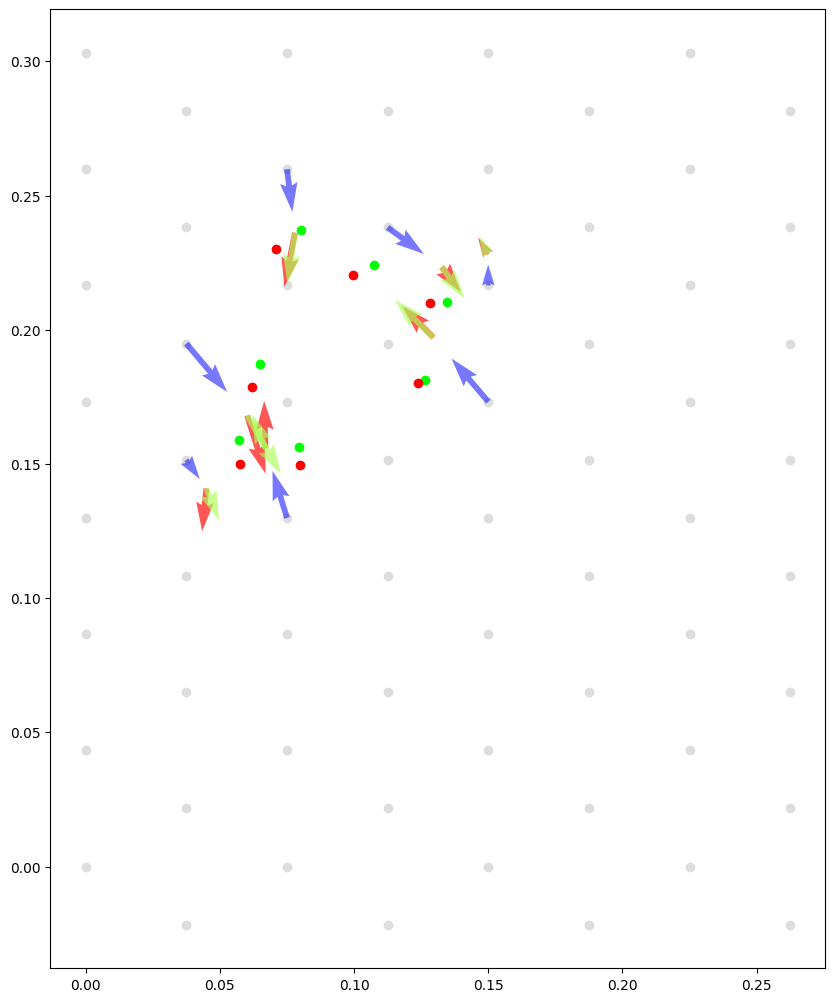

[[-0.0238  0.0083]
 [ 0.0122 -0.0126]
 [-0.0369  0.0036]
 [-0.0339  0.0488]
 [-0.0313  0.0464]]


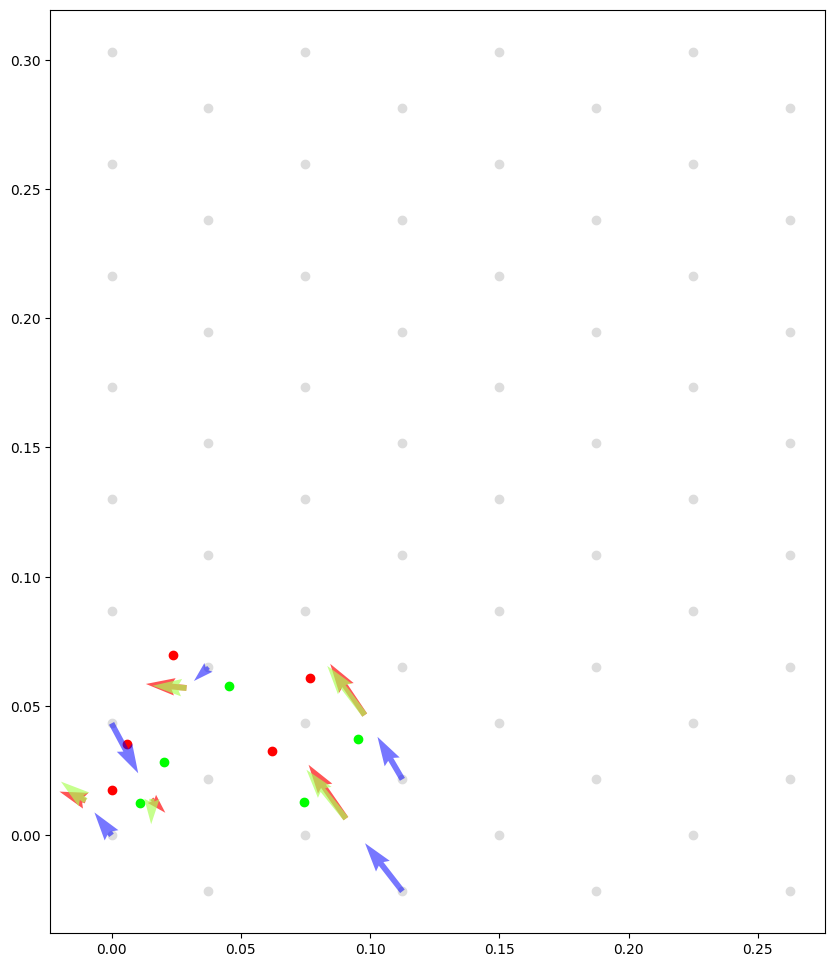

[[ 0.0009  0.0232]
 [ 0.0151 -0.0301]
 [-0.0008  0.0118]
 [-0.0026  0.0052]
 [-0.02   -0.0235]
 [-0.0052  0.0278]]


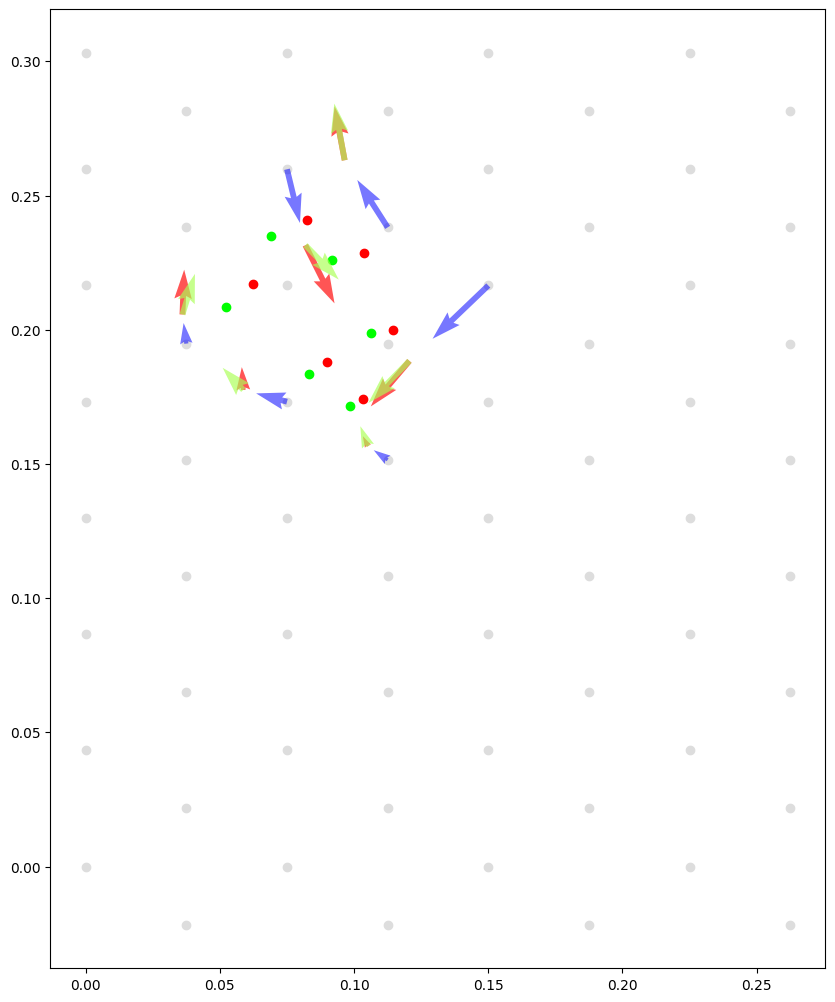

[[ 0.0259  0.0331]
 [ 0.0358  0.0362]
 [ 0.0201  0.0414]
 [ 0.0318 -0.0051]
 [-0.0209  0.0317]
 [ 0.0066  0.0021]
 [-0.0019  0.0037]
 [-0.0056  0.0234]]


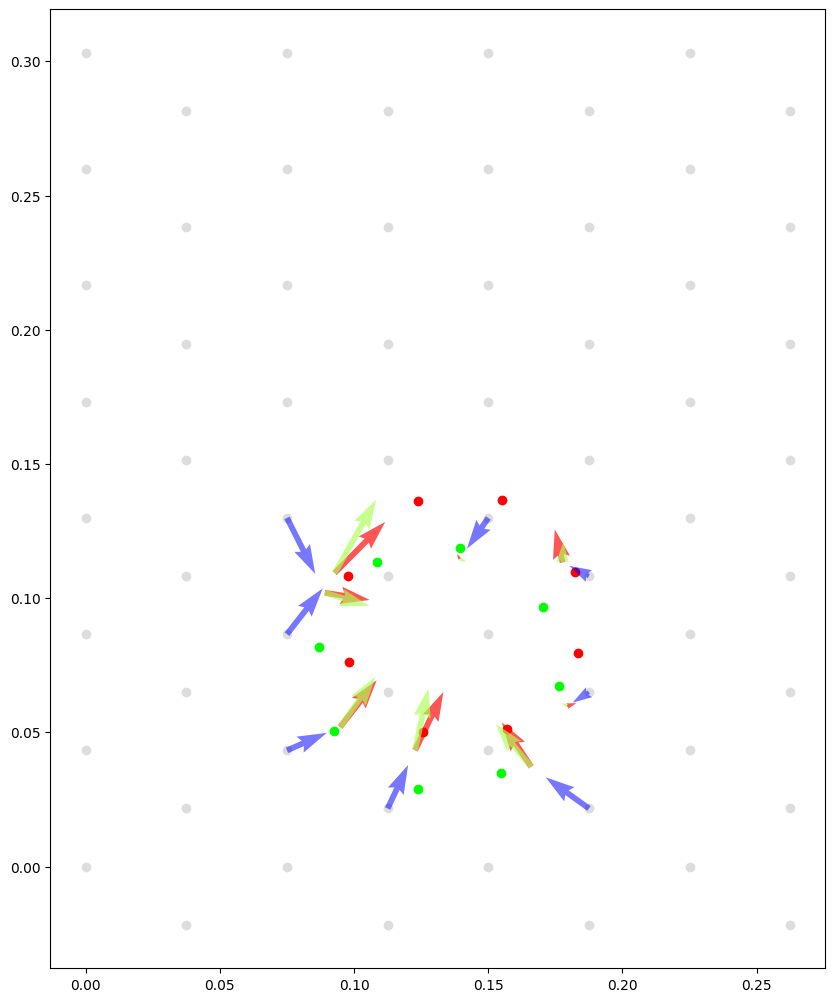

In [29]:
losses = []
for n, (state, action, action_gt, pos) in enumerate(zip(statesss, actionsss, actions_gt, possss)):
    state, action, action_gt, pos = state, action, action_gt, pos
    pos = pos.detach().cpu().numpy()
    acts = action.detach().cpu().numpy()
    acts_gt = action_gt.detach().cpu().numpy()
    state = state.detach().cpu().numpy()


    # state = state_scaler.inverse_transform(state)
    # acts = action_scaler.inverse_transform(acts)
    # acts_gt = action_scaler.inverse_transform(act_gt)

    for n, idx in enumerate(range(state.shape[0])):
    # idx = 0
        po = pos[idx]
        n_agents = len([p for p in po if p != 0])
        r_poses = kdtree_positions_world[po[:n_agents]]
        init_pts = state[idx][:n_agents,:2] + r_poses
        goal_bd_pts = state[idx][:n_agents,2:4] + r_poses
        act_grsp = state[idx][:n_agents,4:6]
        act = acts[idx, :n_agents]
        print(act)
        act_gt = acts_gt[idx, :n_agents]
        r_poses2 = r_poses + act_grsp

        losses.append(np.linalg.norm(act - act_gt))
        # acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        # act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)



        plt.figure(figsize=(10,17.78))
        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:, 0], act[:, 1], color='#ff0000aa')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff55aa')

        plt.gca().set_aspect('equal')
        plt.show()

        if n%50 == 0:
            break

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Dummy function to simulate pretrained diffusion model
def diffusion_model(state):
    # Generates dummy actions conditioned on state
    return np.sin(state) + np.random.normal(scale=0.1, size=state.shape)

# Dummy function to compute the score function for the actions
def compute_score_function(actions):
    # Compute a dummy score function for visualization
    return np.gradient(actions, axis=0)

# Example data
num_samples = 100
state_dim = 3  # Example state dimension
states = np.linspace(-10, 10, num_samples).reshape(-1, 1) * np.ones((1, state_dim))

# Generate actions using the pretrained diffusion model
actions = diffusion_model(states)

# Compute the score function for the actions
score_function = compute_score_function(actions)

# Create a 3D plot of the score function
fig = go.Figure()

for i in range(state_dim):
    # Add traces for each dimension of the score function
    fig.add_trace(go.Scatter3d(
        x=states[:, 0],
        y=actions[:, i],
        z=score_function[:, i],
        mode='lines',
        name=f'Score Dimension {i+1}',
        line=dict(width=4)
    ))

# Customize the layout for better presentation
fig.update_layout(
    title='3D Visualization of the Score Function',
    scene=dict(
        xaxis_title='State',
        yaxis_title='Action',
        zaxis_title='Score'
    ),
    legend=dict(x=0.1, y=0.9)
)

# Show the plot
fig.show()


In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
